<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W0D5_Statistics/student/W0D5_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Statistical Inference
**Week 0, Day 5: Statistics**

**By Neuromatch Academy**

__Content creators:__ Ulrik Beierholm

If an editor really did a lot of content creation add "with help from Name Surname" to the above

__Content reviewers:__ Ethan Cheng, Manisha Sinha

Name Surname, Name Surname. This includes both reviewers and editors. Add reviewers first then editors (paper-like seniority :) ).


---
#Tutorial Objectives

This tutorial builds on Tutorial 1 by explaining how to do inference through inverting the generative process.

By completing the exercises in this tutorial, you should:
* understand what the likelihood function is, and have some intuition of why it is important
* know how to summarise the Gaussian distribution using mean and variance 
* know how to maximise a likelihood function
* be able to do simple inference in both classical and Bayesian ways
* (Optional) understand how Bayes Net can be used to model causal relationships

In [ ]:
#@markdown Tutorial slides (to be added)
# you should link the slides for all tutorial videos here (we will store pdfs on osf)

from IPython.display import HTML
HTML('<iframe src="https://mfr.ca-1.osf.io/render?url=https://osf.io/kaq2x/?direct%26mode=render%26action=download%26mode=render" frameborder="0" width="960" height="569" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>')

---
# Setup
Make sure to run this before you get started

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from numpy.random import default_rng   # a default random number generator
from scipy.stats import norm  # the normal probability distribution

In [ ]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
from ipywidgets import interact, fixed, HBox, Layout, VBox, interactive, Label, interact_manual
%config InlineBackend.figure_format = 'retina'
# plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")

In [ ]:
#@title Plotting & Helper functions

def plot_hist(data, xlabel, figtitle = None, num_bins = None):
  """ Plot the given data as a histogram.

    Args:
      data (ndarray): array with data to plot as histogram
      xlabel (str): label of x-axis
      figtitle (str): title of histogram plot (default is no title)
      num_bins (int): number of bins for histogram (default is 10)

    Returns:
      count (ndarray): number of samples in each histogram bin
      bins (ndarray): center of each histogram bin
  """
  fig, ax = plt.subplots()
  ax.set_xlabel(xlabel)
  ax.set_ylabel('Count')
  if num_bins is not None:
    count, bins, _ = plt.hist(data, max(data), bins = num_bins)
  else:
    count, bins, _ = plt.hist(data, max(data))  # 10 bins default
  if figtitle is not None:
    fig.suptitle(figtitle, size=16)
  plt.show()
  return count, bins

def plot_gaussian_samples_true(samples, xspace, mu, sigma, xlabel, ylabel):
  """ Plot a histogram of the data samples on the same plot as the gaussian
  distribution specified by the give mu and sigma values.

    Args:
      samples (ndarray): data samples for gaussian distribution
      xspace (ndarray): x values to sample from normal distribution
      mu (scalar): mean parameter of normal distribution
      sigma (scalar): variance parameter of normal distribution
      xlabel (str): the label of the x-axis of the histogram
      ylabel (str): the label of the y-axis of the histogram

    Returns:
      Nothing.
  """
  fig, ax = plt.subplots()
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  # num_samples = samples.shape[0]

  count, bins, _ = plt.hist(samples, density=True) # probability density function

  plt.plot(xspace, norm.pdf(xspace, mu, sigma),'r-')
  plt.show()

def plot_likelihoods(likelihoods, mean_vals, variance_vals):
  """ Plot the likelihood values on a heatmap plot where the x and y axes match
  the mean and variance parameter values the likelihoods were computed for.

    Args:
      likelihoods (ndarray): array of computed likelihood values
      mean_vals (ndarray): array of mean parameter values for which the
                            likelihood was computed
      variance_vals (ndarray): array of variance parameter values for which the
                            likelihood was computed

    Returns:
      Nothing.
  """
  fig, ax = plt.subplots()
  im = ax.imshow(likelihoods)

  cbar = ax.figure.colorbar(im, ax=ax)
  cbar.ax.set_ylabel('log likelihood', rotation=-90, va="bottom")

  ax.set_xticks(np.arange(len(mean_vals)))
  ax.set_yticks(np.arange(len(variance_vals)))
  ax.set_xticklabels(mean_vals)
  ax.set_yticklabels(variance_vals)
  ax.set_xlabel('Mean')
  ax.set_ylabel('Variance')

def posterior_plot(x, likelihood=None, prior=None, posterior_pointwise=None, ax=None):
  """
  Plots normalized Gaussian distributions and posterior.

    Args:
        x (numpy array of floats):         points at which the likelihood has been evaluated
        auditory (numpy array of floats):  normalized probabilities for auditory likelihood evaluated at each `x`
        visual (numpy array of floats):    normalized probabilities for visual likelihood evaluated at each `x`
        posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`
        ax: Axis in which to plot. If None, create new axis.

    Returns:
        Nothing.
  """
  if likelihood is None:
      likelihood = np.zeros_like(x)

  if prior is None:
      prior = np.zeros_like(x)

  if posterior_pointwise is None:
      posterior_pointwise = np.zeros_like(x)

  if ax is None:
    fig, ax = plt.subplots()

  ax.plot(x, likelihood, '-C1', LineWidth=2, label='Auditory')
  ax.plot(x, prior, '-C0', LineWidth=2, label='Visual')
  ax.plot(x, posterior_pointwise, '-C2', LineWidth=2, label='Posterior')
  ax.legend()
  ax.set_ylabel('Probability')
  ax.set_xlabel('Orientation (Degrees)')
  plt.show()

  return ax

def plot_classical_vs_bayesian_normal(num_points, mu_classic, var_classic,
                                      mu_bayes, var_bayes):
  """ Helper function to plot optimal normal distribution parameters for varying
  observed sample sizes using both classic and Bayesian inference methods.

    Args:
      num_points (int): max observed sample size to perform inference with
      mu_classic (ndarray): estimated mean parameter for each observed sample size
                                using classic inference method
      var_classic (ndarray): estimated variance parameter for each observed sample size
                                using classic inference method
      mu_bayes (ndarray): estimated mean parameter for each observed sample size
                                using Bayesian inference method
      var_bayes (ndarray): estimated variance parameter for each observed sample size
                                using Bayesian inference method

    Returns:
      Nothing.
  """
  xspace = np.linspace(0, num_points, num_points)
  fig, ax = plt.subplots()
  ax.set_xlabel('n data points')
  ax.set_ylabel('mu')
  plt.plot(xspace, mu_classic,'r-', label = "Classical")
  plt.plot(xspace, mu_bayes,'b-', label = "Bayes")
  plt.legend()
  plt.show()

  fig, ax = plt.subplots()
  ax.set_xlabel('n data points')
  ax.set_ylabel('sigma^2')
  plt.plot(xspace, var_classic,'r-', label = "Classical")
  plt.plot(xspace, var_bayes,'b-', label = "Bayes")
  plt.legend()
  plt.show()

---
# Section 1: Statistical Inference and Likelihood

In [ ]:
#@title Video 4: Inference
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="765S2XKYoJ8", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

A generative model (such as the Gaussian distribution from the previous tutorial) allows us to make prediction about outcomes. 

However, after we observe $n$ data points, we can also evaluate our model (and any of its associated parameters) by calculating the **likelihood** of our model having generated each of those data points $x_i$.

$$P(x_i|\mu,\sigma)=\mathcal{N}(x_i,\mu,\sigma)$$

For all data points $\mathbf{x}=(x_1, x_2, x_3, ...x_n) $ we can then calculate the likelihood for the whole dataset by computing the product of the likelihood for each single data point.

$$P(\mathbf{x}|\mu,\sigma)=\prod_{i=1}^n \mathcal{N}(x_i,\mu,\sigma)$$

As a function of the parameters (when the data points $x$ are fixed), this is referred to as the **likelihood function**, $L(\mu,\sigma)$.

In the last tutorial we reviewed how the data was generated given the selected parameters of the generative process. If we do not know the parameters $\mu$, $\sigma$ that generated the data, we can ask which parameter values (given our model) gives the best (highest) likelihood. 


## Exercise 1A: Likelihood, mean and variance


We can use the likelihood to find the set of parameters that are most likely to have generated the data (given the model we are using). That is, we want to infer the parameters that gave rise to the data we observed. We will try a couple of ways of doing statistical inference.

In the following exercise, we will sample from the Gaussian distribution (again), plot a histogram and the Gaussian probability density function, and calculate some statistics from the samples.

Specifically we will calculate:

*   Likelihood
*   Mean
*   Standard deviation

Statistical moments are defined based on the expectations. The first moment is the expected value, i.e. the mean, the second moment is the expected squared value, i.e. variance, and so on.

The special thing about the Gaussian is that mean and standard deviation of the random sample can effectively approximate the two parameters of a Gaussian, $\mu, \sigma$.

Hence using the sample mean, $\bar{x}=\frac{1}{n}\sum_i x_i$, and variance, $\bar{\sigma}^2=\frac{1}{n} \sum_i (x_i-\bar{x})^2 $ should give us the best/maximum likelihood, $L(\bar{x},\bar{\sigma}^2)$.

Let's see if that actually works. If we search through different combinations of $\mu$ and $\sigma$ values, do the sample mean and variance values give us the maximum likelihood (of observing our data)?

You need to modify two lines below to generate the data from a normal distribution $N(5, 1)$, and plot the theoretical distribution. Note that we are reusing functions from tutorial 1, so review that tutorial if needed. Then you will use this random sample to calculate the likelihood for a variety of potential mean and variance parameter values. For this tutorial we have chosen a variance parameter of 1, meaning the standard deviation is also 1 in this case. Most of our functions take the standard deviation sigma as a parameter, so we will write $\sigma = 1$.

(Note that in practice computing the sample variance like this $$\bar{\sigma}^2=\frac{1}{(n-1)} \sum_i (x_i-\bar{x})^2 $$ is actually better, take a look at any statistics textbook for an explanation of this.)

In [ ]:
def generate_normal_samples(mu, sigma, num_samples):
  """ Generates a desired number of samples from a normal distribution,
  Normal(mu, sigma).

  Args:
    mu (scalar): mean parameter of the normal distribution
    sigma (scalar): standard deviation parameter of the normal distribution
    num_samples (int): number of samples drawn from normal distribution

  Returns:
    sampled_values (ndarray): a array of shape (samples, ) containing the samples
  """
  random_num_generator = default_rng(0)
  sampled_values = random_num_generator.normal(mu, sigma, num_samples)
  return sampled_values

def compute_likelihoods_normal(x, mean_vals, variance_vals):
  """ Computes the log-likelihood values given a observed data sample x, and
  potential mean and variance values for a normal distribution

    Args:
      x (ndarray): 1-D array with all the observed data
      mean_vals (ndarray): 1-D array with all potential mean values to
                              compute the likelihood function for
      variance_vales (ndarray): 1-D array with all potential variance values to
                              compute the likelihood function for

    Returns:
      likelihood (ndarray): 2-D array of shape (number of mean_vals,
                              number of variance_vals) for which the likelihood
                              of the observed data was computed
  """
  # Initialise likelihood collection array
  likelihood = np.zeros((mean_vals.shape[0], variance_vals.shape[0]))

  # Compute the likelihood for observing the gvien data x assuming
  # each combination of mean and variance values
  for idxMean in range(mean_vals.shape[0]):
    for idxVar in range(variance_vals.shape[0]):
      likelihood[idxVar,idxMean]= sum(np.log(norm.pdf(x, mean_vals[idxMean],
                                              variance_vals[idxVar])))

  return likelihood

###################################################################
## TODO for students: Generate 1000 random samples from a normal distribution
## with mu = 5 and sigma = 1
# Fill out the following then remove
raise NotImplementedError("Student exercise: need to generate samples")
###################################################################

# Generate data
mu = 5
sigma = 1  # since variance = 1, sigma = 1
x = ...

# You can calculate mean and variance through either numpy or scipy
print("This is the sample mean as estimated by numpy: " + str(np.mean(x)))
print("This is the sample standard deviation as estimated by numpy: " + str(np.std(x)))
# or
meanX, varX = sp.stats.norm.stats(x)
print("This is the sample mean as estimated by scipy: " + str(meanX[0]))
print("This is the sample standard deviation as estimated by scipy: " + str(varX[0]))

###################################################################
## TODO for students: Use the given function to compute the likelihood for
## a variety of mean and variance values
# Fill out the following then remove
raise NotImplementedError("Student exercise: need to compute likelihoods")
###################################################################

# Let's look through possible mean and variance values for the highest likelihood
# using the compute_likelihood function
meanTest = np.linspace(1, 10, 10) # potential mean values to try
varTest = np.array([0.7, 0.8, 0.9, 1, 1.2, 1.5, 2, 3, 4, 5]) # potential variance values to try
likelihoods = ...

# Uncomment once you've generated the samples and compute likelihoods
# xspace = np.linspace(0, 10, 100)
# plot_gaussian_samples_true(x, xspace, mu, sigma, "x", "Count")
# plot_likelihoods(likelihoods, meanTest, varTest)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D5_Statistics/solutions/W0D5_Tutorial2_Solution_7687f6b1.py)

*Example output:*

<img alt='Solution hint' align='left' width=560 height=416 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W0D5_Statistics/static/W0D5_Tutorial2_Solution_7687f6b1_1.png>

<img alt='Solution hint' align='left' width=534 height=414 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W0D5_Statistics/static/W0D5_Tutorial2_Solution_7687f6b1_2.png>



The top figure shows hopefully a nice fit between the histogram and the distribution that generated the data. So far so good.

Underneath you should see the sample mean and variance values, which are close to the true values (that we happen to know here).

In the heatmap we should be able to see that the mean and variance parameters values yielding the highest likelihood (yellow) corresponds to (roughly) the combination of the calculated sample mean and variance from the dataset.
But it can be hard to see from such a rough **grid-search** simulation, as it is only as precise as the resolution of the grid we are searching. 

Implicitly, by looking for the parameters that give the highest likelihood, we have been searching for the **maximum likelihood** estimate.
$$(\hat{\mu},\hat{\sigma})=argmax_{\mu,\sigma}L(\mu,\sigma)=argmax_{\mu,\sigma} \prod_{i=1}^n \mathcal{N}(x_i,\mu,\sigma)$$.

For a simple Gaussian this can actually be done analytically (you have likely already done so yourself), using the statistical moments: mean and standard deviation (variance). 

In next section we will look at other ways of inferring such parameter variables.

## Interactive Demo: Maximum likelihood inference

We want to do inference on this data set, i.e. we want to infer the parameters that most likely gave rise to the data given our model. Intuitively that means that we want as good as possible a fit between the observed data and the probability distribution function with the best inferred parameters. 

For now, just try to see how well you can fit the probability distribution to the data by using the demo sliders to control the mean and standard deviation parameters of the distribution.

In [ ]:
#@title

#@markdown Make sure you execute this cell to enable the widget and fit by hand!
vals = generate_normal_samples(mu, sigma, 1000)
def plotFnc(mu,sigma):
  #prepare to plot
  fig, ax = plt.subplots()
  ax.set_xlabel('x')
  ax.set_ylabel('probability')
  loglikelihood= sum(np.log(norm.pdf(vals,mu,sigma)))

  #calculate histogram
  count, bins, ignored = plt.hist(vals,density=True)
  x = np.linspace(0,10,100)
  #plot
  plt.plot(x, norm.pdf(x,mu,sigma),'r-')
  plt.show()
  print("The log-likelihood for the selected parameters is: " + str(loglikelihood))

#interact(plotFnc, mu=5.0, sigma=2.1);
#interact(plotFnc, mu=widgets.IntSlider(min=0.0, max=10.0, step=1, value=4.0),sigma=widgets.IntSlider(min=0.1, max=10.0, step=1, value=4.0));
interact(plotFnc, mu=(0.0, 10.0, 0.1),sigma=(0.1, 10.0, 0.1));

Did you notice the number below the plot? That is the summed log-likelihood, which increases (becomes less negative) as the fit improves. The log-likelihood should be greatest when $\mu$ = 5 and $\sigma$ = 1.

Building upon what we did in the previous exercise, we want to see if we can do inference on observed data in a bit more principled way.


## Exercise 1B: Maximum Likelihood Estimation

Let's again assume that we have a data set, $\mathbf{x}$, assumed to be generated by a normal distribution (we actually generate it ourselves in line 1, so we know how it was generated!).
We want to maximise the likelihood of the parameters $\mu$ and $\sigma^2$. We can do so using a couple of tricks:

*   Using a log transform will not change the maximum of the function, but will allow us to work with very small numbers that could lead to problems with machine precision.
*   Maximising a function is the same as minimising the negative of a function, allowing us to use the minimize optimisation provided by scipy.

In the code below, insert the missing line (see the `compute_likelihoods_normal` function from previous exercise), with the mean as theta[0] and variance as theta[1].


In [ ]:
mu = 5
sigma = 1

# Generate 1000 random samples from a Gaussian distribution
dataX = generate_normal_samples(mu, sigma, 1000)

# We define the function to optimise, the negative log likelihood
def negLogLike(theta):
  """ Function for computing the negative log-likelihood given the observed data
  and given parameter values stored in theta.

    Args:
      dataX (ndarray): array with observed data points
      theta (ndarray): normal distribution parameters (mean is theta[0],
                            variance is theta[1])

    Returns:
      Calculated negative Log Likelihood value!
  """
  ###################################################################
  ## TODO for students: Compute the negative log-likelihood value for the
  ## given observed data values and parameters (theta)
  # Fill out the following then remove
  raise NotImplementedError("Student exercise: need to compute the negative \
                                log-likelihood value")
  ###################################################################
  return ...

# Define bounds, var has to be positive
bnds = ((None, None), (0, None))

# Optimize with scipy!
# Uncomment once function above is implemented
# optimal_parameters = sp.optimize.minimize(negLogLike, (2, 2), bounds = bnds)
# print("The optimal mean estimate is: " + str(optimal_parameters.x[0]))
# print("The optimal variance estimate is: " + str(optimal_parameters.x[1]))

# optimal_parameters contains a lot of information about the optimization,
# but we mostly want the mean and variance

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D5_Statistics/solutions/W0D5_Tutorial2_Solution_29984e0b.py)



These are the approximations of the parameters that maximise the likelihood ($\mu$ ~ 5.281 and $\sigma$ ~ 1.170)

Compare these values to the first and second moment (sample mean and variance) from the previous exercise, as well as to the true values (which we only know because we generated the numbers!). Consider the relationship discussed about statistical moments and maximising likelihood.

Go back to the previous exercise and modify the mean and standard deviation values used to generate the observed data $x$, and verify that the values still work out.

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D5_Statistics/solutions/W0D5_Tutorial2_Solution_b0145e28.py)



---
# Section 2: Bayesian Inference

In [ ]:
#@title Video 5: Bayes
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="12tk5FsVMBQ", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


For Bayesian inference we do not focus on the likelihood function $L(y)=P(x|y)$, but instead focus on the posterior distribution: 

$$P(y|x)=\frac{P(x|y)P(y)}{P(x)}$$

which is composed of the likelihood function $P(x|y)$, the prior $P(y)$ and a normalising term $P(x)$ (which we will ignore for now).

While there are other advantages to using Bayesian inference (such as the ability to derive Bayesian Nets, see optional bonus task below), we will first mostly focus on the role of the prior in inference.

## Exercise 2A: Performing Bayesian inference

In the above sections we performed inference using maximum likelihood, i.e. finding the parameters that maximised the likelihood of a set of parameters, given the model and data.

We will now repeat the inference process, but with an added Bayesian prior, and compare it to the classical inference process we did before (Section 1). When using conjugate priors we can just update the parameter values of the distributions (here Gaussian distributions). 

For the prior we start by guessing a mean of 6 (mean of observed data points 5 and 7) and variance of 1 (variance of 5 and 7). This is a simplified way of applying a prior, that allows us to just add these 2 values (pseudo-data) to the real data.

In the code below, complete the missing lines.

In [ ]:
def classic_vs_bayesian_normal(mu, sigma, num_points, prior):
  """ Compute both classical and Bayesian inference processes over the range of
  data sample sizes (num_points) for a normal distribution with parameters
  mu, sigma for comparison.

  Args:
    mu (scalar): the mean parameter of the normal distribution
    sigma (scalar): the standard deviation parameter of the normal distribution
    num_points (int): max number of points to use for inference
    prior (ndarray): prior data points for Bayesian inference

  Returns:
    mean_classic (ndarray): estimate mean parameter via classic inference
    var_classic (ndarray): estimate variance parameter via classic inference
    mean_bayes (ndarray): estimate mean parameter via Bayesian inference
    var_bayes (ndarray): estimate variance parameter via Bayesian inference
  """

  # Initialize the classical and Bayesian inference arrays that will estimate
  # the normal parameters given a certain number of randomly sampled data points
  mean_classic = np.zeros(num_points)
  var_classic = np.zeros(num_points)

  mean_bayes = np.zeros(num_points)
  var_bayes = np.zeros(num_points)

  for nData in range(num_points):

    ###################################################################
    ## TODO for students: Complete classical inference for increasingly
    ## larger sets of random data points
    # Fill out the following then remove
    raise NotImplementedError("Student exercise: need to code classical inference")
    ###################################################################

    # Randomly sample nData + 1 number of points
    x = ...
    # Compute the mean of those points and set the corresponding array entry to this value
    mean_classic[nData] = ...
    # Compute the variance of those points and set the corresponding array entry to this value
    var_classic[nData] = ...

    # Bayesian inference with the given prior is performed below for you
    xsupp = np.hstack((x, prior))
    mean_bayes[nData] = np.mean(xsupp)
    var_bayes[nData] = np.var(xsupp)

  return mean_classic, var_classic, mean_bayes, var_bayes

# Set normal distribution parameters, mu and sigma
mu = 5
sigma = 1

# Set the prior to be two new data points, 5 and 7, and print the mean and variance
prior = np.array((5, 7))
print("The mean of the data comprising the prior is: " + str(np.mean(prior)))
print("The variance of the data comprising the prior is: " + str(np.var(prior)))

# Uncomment once the function above is completed
# mean_classic, var_classic, mean_bayes, var_bayes = classic_vs_bayesian_normal(mu, sigma, 30, prior)
# plot_classical_vs_bayesian_normal(30, mean_classic, var_classic, mean_bayes, var_bayes)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D5_Statistics/solutions/W0D5_Tutorial2_Solution_4cfc70ca.py)

*Example output:*

<img alt='Solution hint' align='left' width=560 height=416 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W0D5_Statistics/static/W0D5_Tutorial2_Solution_4cfc70ca_1.png>

<img alt='Solution hint' align='left' width=560 height=416 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W0D5_Statistics/static/W0D5_Tutorial2_Solution_4cfc70ca_2.png>



Hopefully you can see that the blue line stays a little closer to the true values ($\mu=5$, $\sigma^2=1$). Having a simple prior in the Bayesian inference process (blue) helps to regularise the inference of the mean and variance parameters when you have very little data, but has little effect with large data. You can see that as the number of data points (x-axis) increases, both inference processes (blue and red lines) get closer and closer together, i.e. their estimates for the true parameters converge as sample size increases.

## Think! 2A: Bayesian Brains
It should be clear how Bayesian inference can help you when doing data analysis. But consider whether the brain might be able to benefit from this too. If the brain needs to make inferences about the world, would it be useful to do regularisation on the input? 

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D5_Statistics/solutions/W0D5_Tutorial2_Solution_daa12602.py)



## Exercise 2B: Finding the posterior computationally
***(Exercise moved  from NMA2020 Bayes day, all credit to original creators!)***

Imagine an experiment where participants estimate the location of a noise-emitting object. To estimate its position, the participants can use two sources of information: 
  1. new noisy auditory information (the likelihood)
  2. prior visual expectations of where the stimulus is likely to come from (visual prior). 

The auditory and visual information are both noisy, so participants will combine these sources of information to better estimate the position of the object.

We will use Gaussian distributions to represent the auditory likelihood (in red), and a Gaussian visual prior (expectations - in blue). Using Bayes rule, you will combine them into a posterior distribution that summarizes the probability that the object is in each possible location. 

We have provided you with a ready-to-use plotting function, and a code skeleton.

* You can use `my_gaussian` from Tutorial 1 (also included below), to generate an auditory likelihood with parameters $\mu$ = 3 and $\sigma$ = 1.5
* Generate a visual prior with parameters $\mu$ = -1 and $\sigma$ = 1.5
* Calculate the posterior using pointwise multiplication of the likelihood and prior. Don't forget to normalize so the posterior adds up to 1
* Plot the likelihood, prior and posterior using the predefined function `posterior_plot`



In [ ]:
def my_gaussian(x_points, mu, sigma):
  """ Returns normalized Gaussian estimated at points `x_points`, with parameters:
  mean `mu` and standard deviation `sigma`

  Args:
      x_points (ndarray of floats): points at which the gaussian is evaluated
      mu (scalar): mean of the Gaussian
      sigma (scalar): standard deviation of the gaussian

  Returns:
      (numpy array of floats) : normalized Gaussian evaluated at `x`
  """
  px = 1/(2*np.pi*sigma**2)**1/2 *np.exp(-(x_points-mu)**2/(2*sigma**2))

  # as we are doing numerical integration we may have to remember to normalise
  # taking into account the stepsize (0.1)
  px = px/(0.1*sum(px))
  return px

def compute_posterior_pointwise(prior, likelihood):
  """ Compute the posterior probability distribution point-by-point using Bayes
  Rule.

    Args:
      prior (ndarray): probability distribution of prior
      likelihood (ndarray): probability distribution of likelihood

    Returns:
      posterior (ndarray): probability distribution of posterior
  """
  ##############################################################################
  # TODO for students: Write code to compute the posterior from the prior and
  # likelihood via pointwise multiplication. (You may assume both are defined
  # over the same x-axis)
  #
  # Comment out the line below to test your solution
  raise NotImplementedError("Finish the simulation code first")
  ##############################################################################

  posterior = ...

  return posterior

def localization_simulation(mu_auditory = 3.0, sigma_auditory = 1.5,
                            mu_visual = -1.0, sigma_visual = 1.5):
  """ Perform a sound localization simulation with an auditory prior.

    Args:
      mu_auditory (float): mean parameter value for auditory prior
      sigma_auditory (float): standard deviation parameter value for auditory
                                prior
      mu_visual (float): mean parameter value for visual likelihood distribution
      sigma_visual (float): standard deviation parameter value for visual
                                likelihood distribution

    Returns:
      x (ndarray): range of values for which to compute probabilities
      auditory (ndarray): probability distribution of the auditory prior
      visual (ndarray): probability distribution of the visual likelihood
      posterior_pointwise (ndarray): posterior probability distribution
  """
  ##############################################################################
  ## Using the x variable below,
  ##      create a gaussian called 'auditory' with mean 3, and std 1.5
  ##      create a gaussian called 'visual' with mean -1, and std 1.5
  #
  #
  ## Comment out the line below to test your solution
  raise NotImplementedError("Finish the simulation code first")
  ###############################################################################
  x = np.arange(-8, 9, 0.1)

  auditory = ...
  visual = ...
  posterior = compute_posterior_pointwise(auditory, visual)

  return x, auditory, visual, posterior


# Uncomment the lines below to plot the results
# x, auditory, visual, posterior_pointwise = localization_simulation()
# _ = posterior_plot(x, auditory, visual, posterior_pointwise)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D5_Statistics/solutions/W0D5_Tutorial2_Solution_ab4b98de.py)

*Example output:*

<img alt='Solution hint' align='left' width=560 height=416 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W0D5_Statistics/static/W0D5_Tutorial2_Solution_ab4b98de_1.png>



Combining the the visual and auditory information could help the brain get a better estimate of the location of an audio-visual object, with lower variance. For this specific example we did not use a Bayesian prior for simplicity, although it would be a good idea in a practical modeling study.

**Main course preview:** On Week 3 Day 1 (W3D1) there will be a whole day devoted to examining whether the brain uses Bayesian inference. Is the brain Bayesian?!

---
# Summary


In [ ]:
#@title Video 6: Outro
from IPython.display import YouTubeVideo
video = YouTubeVideo(id= "BL5qNdZS-XQ", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


Having done the different exercises you should now:
* understand what the likelihood function is, and have some intuition of why it is important
* know how to summarise the Gaussian distribution using mean and variance 
* know how to maximise a likelihood function
* be able to do simple inference in both classical and Bayesian ways

---
# Bonus

For more reading on these topics see:
Textbook



## Extra exercise: Bayes Net
If you have the time, here is another extra exercise.

Bayes Net, or Bayesian Belief Networks, provide a way to make inferences about multiple levels of information, which would be very difficult to do in a classical frequentist paradigm.

We can encapsulate our knowledge about causal relationships and use this to make inferences about hidden properties.

We will try a simple example of a Bayesian Net (aka belief network). Imagine that you have a house with an unreliable sprinkler system installed for watering the grass. This is set to water the grass independently of whether it has rained that day. We have three variables, rain ($r$), sprinklers ($s$) and wet grass ($w$). Each of these can be true (1) or false (0). See the graphical model representing the relationship between the variables.

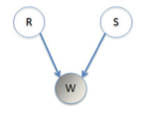

There is a table below describing all the relationships between $w, r$, and s$.

Obviously the grass is more likely to be wet if either the sprinklers were on or it was raining. On any given day the sprinklers have probability 0.25 of being on, $P(s = 1) = 0.25$, while there is a probability 0.1 of rain, $P (r = 1) = 0.1$. The table then lists the conditional probabilities for the given being wet, given a rain and sprinkler condition for that day.

\begin{array}{|l |  l || ll |} \hline
r &s&P(w=0|r,s) &P(w=1|r,s)$\\ \hline
0& 0  &0.999 &0.001\\
0& 1 &0.1& 0.9\\
1& 0 &0.01 &0.99\\
1& 1& 0.001 &0.999\\ \hline
\end{array}



You come home and find that the the grass is wet, what is the probability the sprinklers were on today (you do not know if it was raining)?

We can start by writing out the joint probability:
$P(r,w,s)=P(w|r,s)P(r)P(s)$

The conditional probability is then:

$
P(s|w)=\frac{\sum_{r} P(w|s,r)P(s)  P(r)}{P(w)}=\frac{P(s) \sum_{r} P(w|s,r) P(r)}{P(w)}
$

Note that we are summing over all possible conditions for $r$ as we do not know if it was raining. Specifically, we want to know the probability of sprinklers having been on given the wet grass, $P(s=1|w=1)$:

$
P(s=1|w=1)=\frac{P(s = 1)( P(w = 1|s = 1, r = 1) P(r = 1)+ P(w = 1|s = 1,r = 0)  P(r = 0))}{P(w = 1)} 
$

where

\begin{eqnarray}
P(w=1)=P(s=1)( P(w=1|s=1,r=1 ) P(r=1) &+ P(w=1|s=1,r=0)  P(r=0))\\
+P(s=0)( P(w=1|s=0,r=1 )  P(r=1) &+ P(w=1|s=0,r=0)  P(r=0))\\
\end{eqnarray}

This code has been written out below, you just need to insert the right numbers from the table.

In [ ]:
##############################################################################
# TODO for student: Write code to insert the correct conditional probabilities
# from the table; see the comments to match variable with table entry.
# Comment out the line below to test your solution
raise NotImplementedError("Finish the simulation code first")
##############################################################################

Pw1r1s1 = ...  # the probability of wet grass given rain and sprinklers on
Pw1r1s0 = ...  # the probability of wet grass given rain and sprinklers off
Pw1r0s1 = ...  # the probability of wet grass given no rain and sprinklers on
Pw1r0s0 = ...  # the probability of wet grass given no rain and sprinklers off
Ps = ... # the probability of the sprinkler being on
Pr = ... # the probability of rain that day


# Uncomment once variables are assigned above
# A= Ps * (Pw1r1s1 * Pr + (Pw1r0s1) * (1 - Pr))
# B= (1 - Ps) * (Pw1r1s0 *Pr + (Pw1r0s0) * (1 - Pr))
# print("Given that the grass is wet, the probability the sprinkler was on is: " +
#       str(A/(A + B)))

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W0D5_Statistics/solutions/W0D5_Tutorial2_Solution_204db048.py)



The probability you should get is about 0.7522.

Your neighbour now tells you that it was indeed 
raining today, $P (r = 1) = 1$, so what is now the probability the sprinklers were on? Try changing the numbers above.



## Think! Bonus: Causality in the Brain

In a causal stucture this is the correct way to calculate the probabilities. Do you think this is how the brain solves such problems? Would it be different for task involving novel stimuli (e.g. for someone with no previous exposure to sprinklers), as opposed to common stimuli?

**Main course preview:** On W3D5 we will discuss causality further!